# Naive Bayes & KNN Classifiers

<div style="text-align: right"> 
<h3>Machine Learning - PPG IC-UFF 2017.1</h3>
<h4>Daniel Junior</h4>
</div>

In [24]:
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import numpy as np
import math
import itertools
from collections import Counter
from operator import itemgetter
from scipy.stats import multivariate_normal as mvn
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

iris = load_iris()
X = iris.data
y = iris.target

## 1 - Naive Bayes

In [25]:
class NaiveBayes():
    def __init__(self, params=None):
        'If params is None the method is initialized with default values.'
        pass
    
    def predict(self,X):
        classes_gaussians = len(self.gaussians)
        examples, features_number = X.shape
        probabilities = np.zeros((examples,classes_gaussians))

        for cls,gaussian in self.gaussians.items():
            mean, var = gaussian['mean'], gaussian['var']
            probabilities[:,cls] = mvn.pdf(X, mean=mean, cov=var) * self.classes_prior_probs[cls]
        return np.argmax(probabilities, axis=1)
    
    def learn(self,X,y):
        classes = set(y)
        self.gaussians = {}
        self.classes_prior_probs = {}
        for label in classes:
            evidence = X[y == label]
            self.gaussians[label] = {
                'mean': evidence.mean(axis=0),
                'var': evidence.var(axis=0)
            }
            self.classes_prior_probs[label] = (len(y[y==label])/len(y))


In [26]:
nb = NaiveBayes()

skf = StratifiedKFold(n_splits=10)
acc_scores = []
recall_scores = []
f1_scores = []
precision_scores = []
for train, test in skf.split(X, y):
    nb.learn(X[train], y[train])
    y_pred = nb.predict(X[test])
    acc_scores.append(accuracy_score(y[test], y_pred))
    recall_scores.append(recall_score(y[test], y_pred, average='micro'))
    f1_scores.append(f1_score(y[test], y_pred, average='micro'))
    precision_scores.append(precision_score(y[test], y_pred, average='micro'))

### Metrics

In [35]:
print("Stratified 10-Fold Cross-Validation\n")
print("Mean Accuracy: %s" % (np.mean(acc_scores) * 100))
print("Standard deviation accuracy: %s" %  np.array(acc_scores).std())
print("Mean Recall: %s" % (np.mean(recall_scores) * 100))
print("Standard deviation accuracy: %s" %  np.array(recall_scores).std())
print("Mean F1-Score: %s" % (np.mean(f1_scores) * 100))
print("Standard deviation accuracy: %s" %  np.array(f1_scores).std())
print("Mean Precision: %s" % (np.mean(precision_scores) * 100))
print("Standard deviation accuracy: %s" %  np.array(precision_scores).std())

Stratified 10-Fold Cross-Validation

Mean Accuracy: 95.3333333333
Standard deviation accuracy: 0.0426874949162
Mean Recall: 95.3333333333
Standard deviation accuracy: 0.0426874949162
Mean F1-Score: 95.3333333333
Standard deviation accuracy: 0.0426874949162
Mean Precision: 95.3333333333
Standard deviation accuracy: 0.0426874949162


### Visualization

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
nb.learn(X_train,y_train)
y_pred = nb.predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()

plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(set(y)))
plt.xticks(tick_marks, set(y), rotation=45)
plt.yticks(tick_marks, set(y))

thresh = cnf_matrix.max() / 2.
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

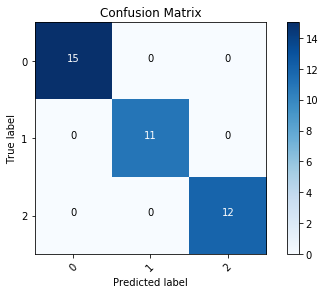

In [38]:
plt.show()

## 2 - KNN

In [29]:
class KNN():
    def __init__(self, params=None):
        if params == None:    
            self.K = 10
            self.D = 'euclidean'  
        else:
            self.K = params['k']
            self.D = params['d']
    
    def predict(self,X):
        #from IPython.core.debugger import Tracer; Tracer()()
        if X.ndim > 1:
            resp = np.array([])
            for x in X:
                neighbours = self.getNeighbors(self.training_set,x,self.K)
                classes = [neighbour[0][1] for neighbour in neighbours]
                count = Counter(classes)
                resp = np.append(resp,count.most_common()[0][0])
            return resp
        else:
            neighbours = self.getNeighbors(self.training_set,X,self.K)
            classes = [neighbour[0][1] for neighbour in neighbours]
            count = Counter(classes)
            return count.most_common()[0][0]
    
    def predict_instance(self, x):
        neighbours = self.getNeighbors(self.training_set,X,self.K)
        classes = [neighbour[0][1] for neighbour in neighbours]
        count = Counter(classes)
        return count.most_common()[0][0]
    
    
    def learn(self,X,y):
        self.training_set = np.array(list(zip(X,y)))
        
    
    def euclidean_distance(self,instance1, instance2, length = 2):
        distance = 0
        for x in range(length):
            distance += pow((instance1[x] - instance2[x]), length)
        return math.sqrt(distance)
    
    def manhattan_distance(self,instance1, instance2):
        return sum(abs(a-b) for a,b in zip(instance1,instance2))
    
    def _get_tuple_distance(self,training_instance, test_instance):
        if self.D == 'euclidean':
            return (training_instance, self.euclidean_distance(test_instance, training_instance[0],2))
        else:
            return (training_instance, self.manhattan_distance(test_instance, training_instance[0]))
            
    def getNeighbors(self,training_set, test_instance, k):
        distances = [self._get_tuple_distance(training_instance, test_instance) for training_instance in training_set]
        distances = sorted(distances,key=itemgetter(1))
        return distances[:k]

In [30]:
ks = []
accs_eucl = []
accs_man = []

for k in range(1,11):
    knn_eucl = KNN(params={'k':k,'d':'euclidean'})
    knn_man = KNN(params={'k':k,'d':'manhattan'})
    
    skf = StratifiedKFold(n_splits=10)
    acc_scores_eucl = []
    acc_scores_man = []
    for train, test in skf.split(X, y):
        knn_eucl.learn(X[train], y[train])
        knn_man.learn(X[train], y[train])
        y_pred_eucl = knn_eucl.predict(X[test])
        y_pred_man = knn_man.predict(X[test]) 
        acc_scores_eucl.append(accuracy_score(y[test], y_pred_eucl))
        acc_scores_man.append(accuracy_score(y[test], y_pred_man))
    ks.append(k)
    accs_eucl.append((np.mean(acc_scores_eucl) * 100))
    accs_man.append((np.mean(acc_scores_man) * 100))    

### Metrics

In [34]:
print("Stratified 10-Fold Cross-Validation\n")

print("Euclidean Mean Accuracy: %s" % (np.mean(acc_scores_eucl) * 100))
print("Euclidean Standard deviation accuracy: %s" %  np.array(acc_scores_eucl).std())

print("Manhattan Mean Accuracy: %s" % (np.mean(acc_scores_man) * 100))
print("Manhattan Standard deviation accuracy: %s" %  np.array(acc_scores_man).std())


Stratified 10-Fold Cross-Validation

Euclidean Mean Accuracy: 78.6666666667
Euclidean Standard deviation accuracy: 0.0718021974285
Manhattan Mean Accuracy: 95.3333333333
Manhattan Standard deviation accuracy: 0.0426874949162


### Visualization

In [32]:
# f, subplots = plt.subplots(1, 2)

# subplots[0].set_title("Euclidian Distance (K=1...10)")
# subplots[0].plot(ks, accs_eucl)
# subplots[0].set_ylabel('Mean Accuracy')
# subplots[0].set_xlabel('K')

# subplots[1].set_title("Manhattan Distance (K=1...10)")
# subplots[1].plot(ks, accs_man)
# subplots[1].set_ylabel('Mean Accuracy')
# subplots[1].set_xlabel('K')

# plt.tight_layout()
# plt.show()


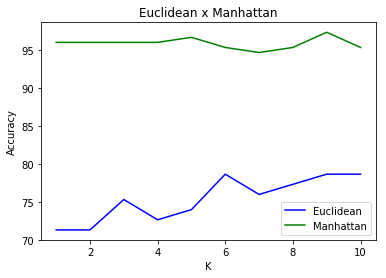

In [33]:
plt.plot(ks, accs_eucl, 'b-', label='Euclidean')
plt.plot(ks, accs_man, 'g-', label='Manhattan')
plt.title('Euclidean x Manhattan')
plt.ylabel('Accuracy')
plt.xlabel('K')
plt.legend()
plt.show()